<a href="https://colab.research.google.com/github/fathursidiq/CNN/blob/main/shap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd

In [ ]:
seq_length = 1
num_sequences = 1
batch_size = 32
class ConvBiLSTM(nn.Module):
    def __init__(self):
        super(ConvBiLSTM, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=128, kernel_size=3, padding=1)
        self.bilstm = nn.LSTM(input_size=128, hidden_size=256, num_layers=1, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(512, 2)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension
        x = torch.relu(self.conv1(x))
        x = x.permute(0, 2, 1)  # Reshape for LSTM: (batch, seq, feature)
        x, _ = self.bilstm(x)
        x = self.fc(x)
        return x
model = ConvBiLSTM()

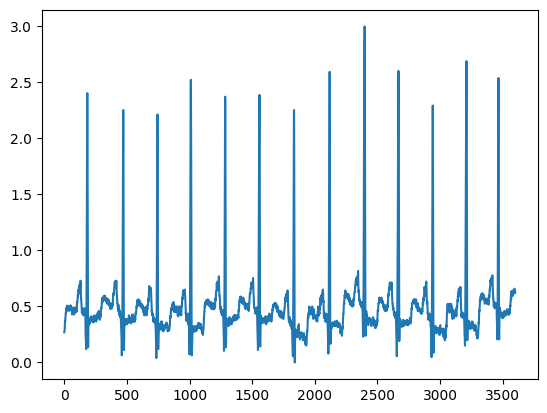

In [ ]:
#input sinyal
da = pd.read_csv('/media/fathur/DEGAN1/BIsmillah/ECGCSVMLII1NSR/5.csv', delimiter=';')['data']
normalized_dat = (da - np.min(da)) / (np.max(da) - np.min(da)) * 3
plt.plot(normalized_dat)
plt.show()
X = np.array(normalized_dat[:3300]).reshape(1,3300)
X=torch.tensor(X, dtype=torch.float32)

/tmp/ipykernel_3850/1918487153.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))
[W1128 10:09:34.012941718 NNPACK.cpp:61] Cou

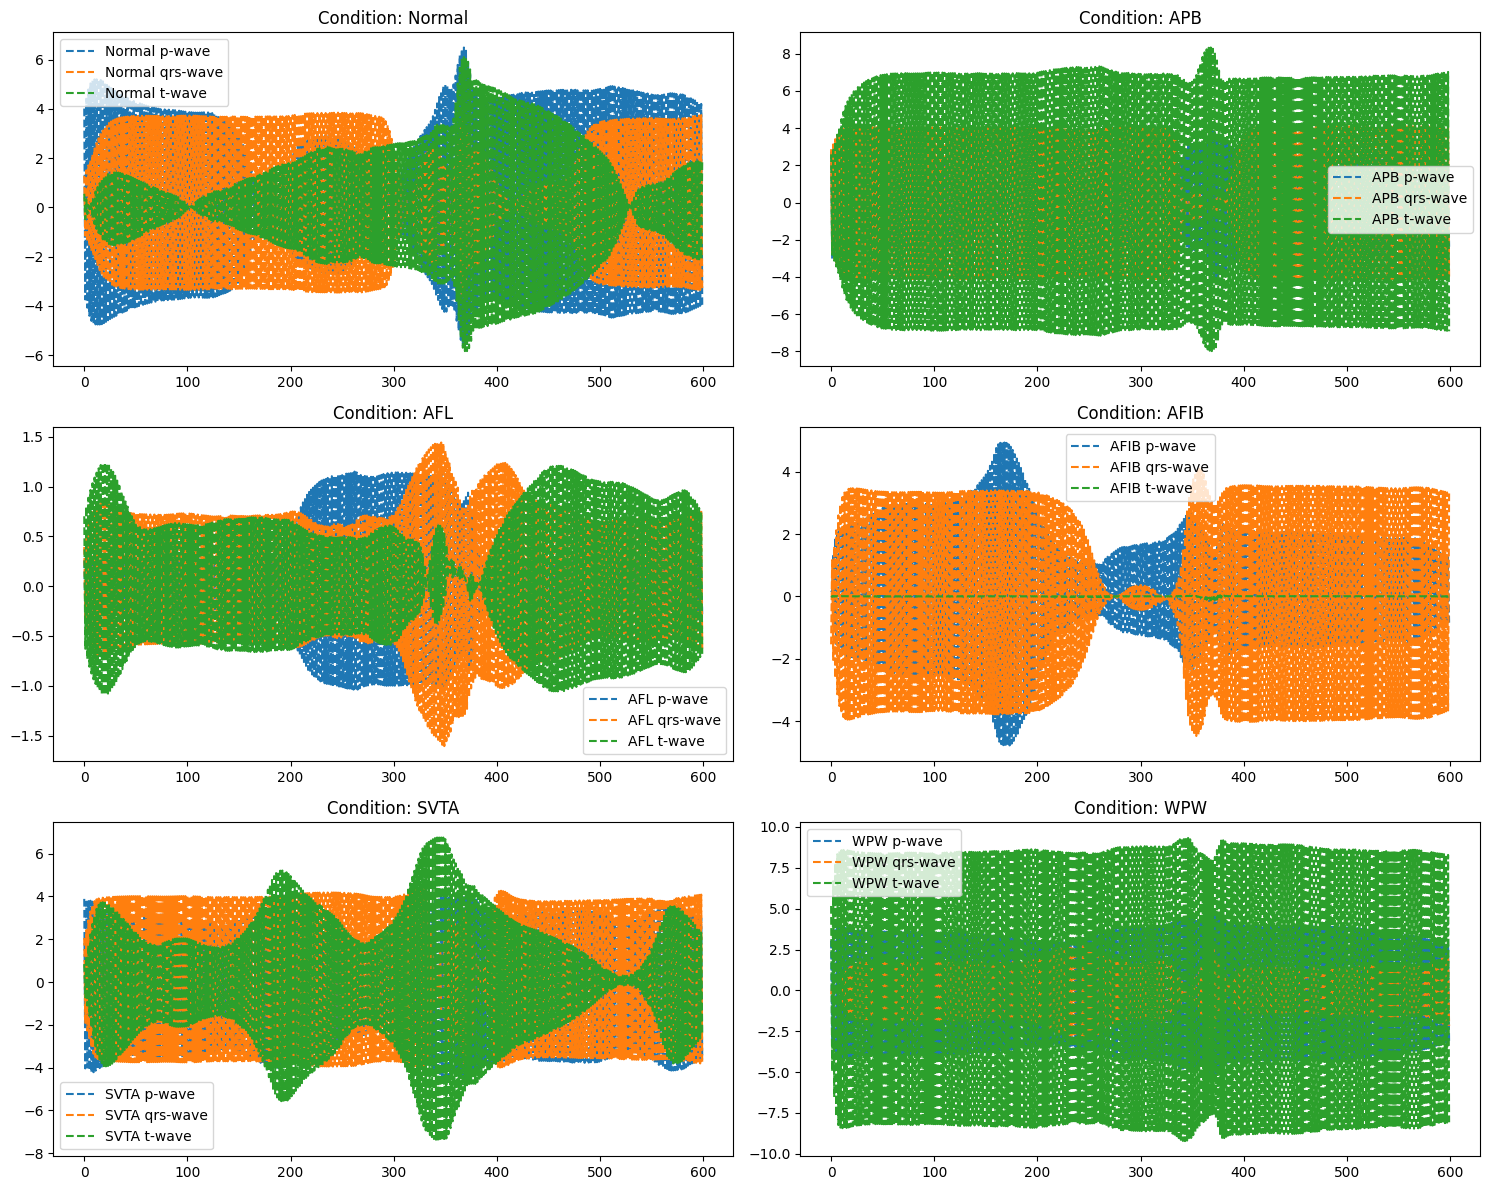

In [ ]:
class ECGModelProcessor:
    def __init__(self, model_paths):
        self.models = {name: self._load_model(path) for name, path in model_paths.items()}

    @staticmethod
    def _load_model(model_path):
        model = ConvBiLSTM()  # Ensure ConvBiLSTM is defined elsewhere in your code
        model.load_state_dict(torch.load(model_path))
        model.eval()
        return model

    def predict(self, X):
        predictions = {}
        with torch.no_grad():
            for name, model in self.models.items():
                output = model(X)
                predictions[name] = output
        return predictions

    def explain_predictions(self, X):
        explanations = {}
        for name, model in self.models.items():
            explainer = shap.DeepExplainer(model, X)  # Use DeepExplainer for deep learning models
            shap_values = explainer.shap_values(X)
            explanations[name] = shap_values
        return explanations
    @staticmethod
    def plot_results(X, predictions, conditions, labels, signal_length=600):

        plt.figure(figsize=(15, 12))
        for i, condition in enumerate(conditions, 1):
            plt.subplot(3, 2, i)
            #plt.plot(X.flatten()[:signal_length], label='Signal ECG')
            for wave, label in labels.items():
                plt.plot(predictions[f"{condition}_{wave}"].flatten()[:signal_length],
                         label=f"{condition} {label}", linestyle='--')
            plt.legend()
            plt.title(f"Condition: {condition}")
        plt.tight_layout()
        plt.show()

# Define model paths
model_paths = {
    "Normal_p": "/media/fathur/DEGAN1/model_ecg_fix/Normal1/p.pth",
    "Normal_qrs": "/media/fathur/DEGAN1/model_ecg_fix/Normal1/qrs.pth",
    "Normal_t": "/media/fathur/DEGAN1/model_ecg_fix/Normal1/t.pth",
    "APB_p": "/media/fathur/DEGAN1/model_ecg_fix/APB2/p.pth",
    "APB_qrs": "/media/fathur/DEGAN1/model_ecg_fix/APB2/qrs.pth",
    "APB_t": "/media/fathur/DEGAN1/model_ecg_fix/APB2/t.pth",
    "AFL_p": "/media/fathur/DEGAN1/model_ecg_fix/AFL3/p.pth",
    "AFL_qrs": "/media/fathur/DEGAN1/model_ecg_fix/AFL3/qrs.pth",
    "AFL_t": "/media/fathur/DEGAN1/model_ecg_fix/AFL3/t.pth",
    "AFIB_p": "/media/fathur/DEGAN1/model_ecg_fix/AFIB4/p.pth",
    "AFIB_qrs": "/media/fathur/DEGAN1/model_ecg_fix/AFIB4/qrs.pth",
    "AFIB_t": "/media/fathur/DEGAN1/model_ecg_fix/AFIB4/t.pth",
    "SVTA_p": "/media/fathur/DEGAN1/model_ecg_fix/SVTA5/p.pth",
    "SVTA_qrs": "/media/fathur/DEGAN1/model_ecg_fix/SVTA5/qrs.pth",
    "SVTA_t": "/media/fathur/DEGAN1/model_ecg_fix/SVTA5/t.pth",
    "WPW_p": "/media/fathur/DEGAN1/model_ecg_fix/WPW6/p.pth",
    "WPW_qrs": "/media/fathur/DEGAN1/model_ecg_fix/WPW6/qrs.pth",
    "WPW_t": "/media/fathur/DEGAN1/model_ecg_fix/WPW6/t.pth",
}

# Instantiate the processor and load models
processor = ECGModelProcessor(model_paths)


# Generate predictions
predictions = processor.predict(X)

# Define conditions and labels
conditions = ["Normal", "APB", "AFL", "AFIB", "SVTA", "WPW"]
labels = {"p": "p-wave", "qrs": "qrs-wave", "t": "t-wave"}

# Plot results
processor.plot_results(X, predictions, conditions, labels)

/tmp/ipykernel_3850/1918487153.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Mean prediction values for each condition and wave:
Normal: {'p': 0.18374711275100708, 'qrs': 0.13732340931892395, 't': 0.03184955194592476}
APB: {'p': -0.09316793084144592, 'qrs': -0.03562488779425621, 't': 0.03508426621556282}
AFL: {'p': 0.026680732145905495, 'qrs': 0.04626059904694557, 't': 0.04267101734876633}
AFIB: {'p': 0.19284848868846893, 'qrs': -0.16891975700855255, 't': 0.0029787623789161444}
SVTA: {'p': -0.2322690337896347, 'qrs': 0.11049419641494751, 't': -0.10440215468406677}
WPW: {'p': -0.19431602954864502, 'qrs': -0.025845050811767578, 't': 0.09470969438552856}

Total scores for each condition:
Normal: 0.3529200740158558
APB: 0.09370855242013931
AFL: 0.1156123485416174
AFIB: 0.026907494058832526
SVTA: 0.22617699205875397
WPW: 0.12545138597488403

Overall dominant condition: Normal


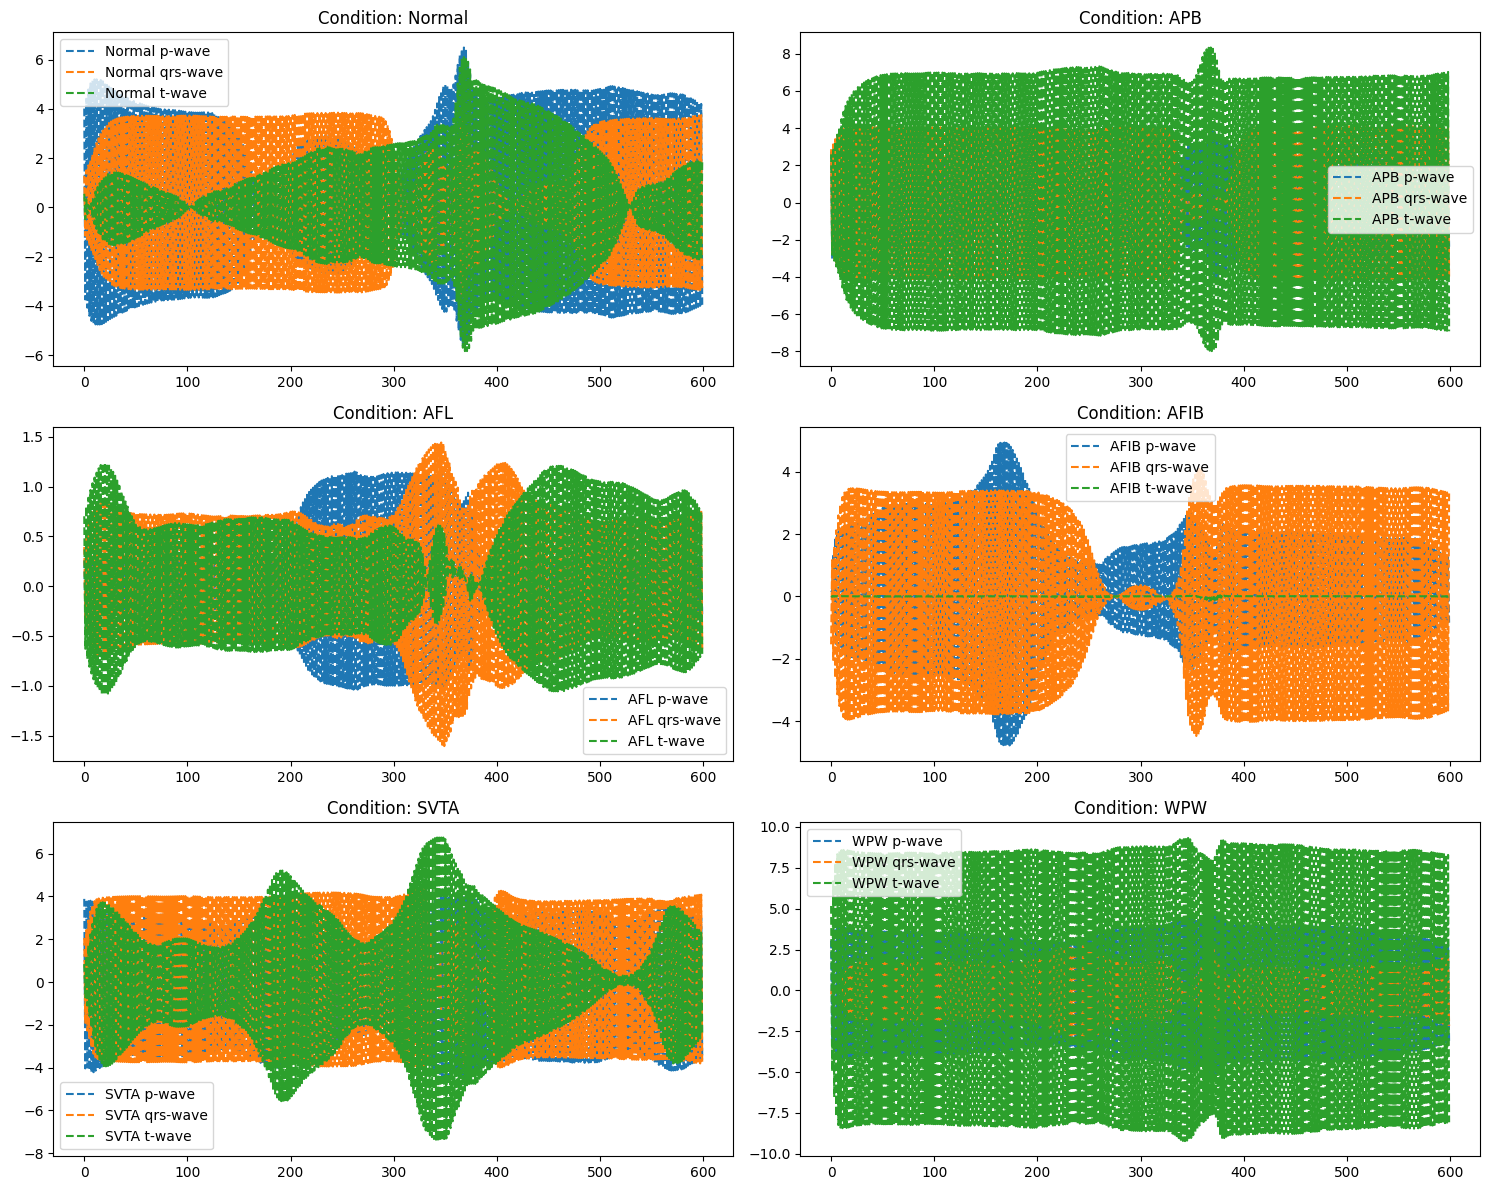

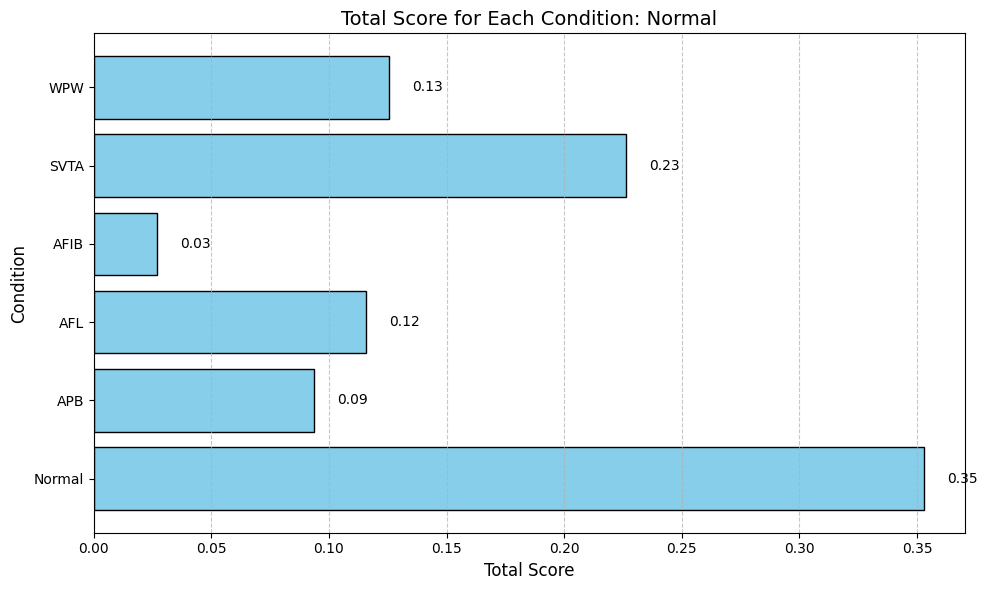

In [ ]:
def determine_dominant_class(predictions):
    """
    Determine the dominant class based on model predictions.
    """
    conditions = ["Normal", "APB", "AFL", "AFIB", "SVTA", "WPW"]
    waves = ["p", "qrs", "t"]

    # Compute mean prediction values for each condition and wave
    mean_values = {condition: {wave: predictions[f"{condition}_{wave}"].mean().item() for wave in waves} for condition in conditions}

    # Calculate total score for each condition
    total_scores = {condition: np.abs(sum(mean_values[condition].values())) for condition in conditions}

    # Determine the overall dominant condition
    overall_dominant_condition = max(total_scores, key=total_scores.get)

    return mean_values, total_scores, overall_dominant_condition

def plot_total_scores_bar(total_scores):
    """
    Plot a bar chart for the total scores of each condition.
    """
    plt.figure(figsize=(10, 6))
    conditions = list(total_scores.keys())
    scores = list(total_scores.values())

    # Plot bar chart
    plt.barh(conditions, scores, color='skyblue', edgecolor='black')
    plt.xlabel('Total Score', fontsize=12)
    plt.ylabel('Condition', fontsize=12)
    plt.title('Total Score for Each Condition'f": {overall_dominant_condition}", fontsize=14)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    for index, value in enumerate(scores):
        plt.text(value + 0.01, index, f"{value:.2f}", va='center', fontsize=10)  # Annotate scores
    plt.tight_layout()
    plt.show()



# Instantiate the processor and load models
processor = ECGModelProcessor(model_paths)

# Generate predictions
predictions = processor.predict(X)

# Determine dominant class
mean_values, total_scores, overall_dominant_condition = determine_dominant_class(predictions)

# Print results
print("Mean prediction values for each condition and wave:")
for condition, scores in mean_values.items():
    print(f"{condition}: {scores}")

print("\nTotal scores for each condition:")
for condition, score in total_scores.items():
    print(f"{condition}: {score}")

print(f"\nOverall dominant condition: {overall_dominant_condition}")

# Plot results
conditions = ["Normal", "APB", "AFL", "AFIB", "SVTA", "WPW"]
labels = {"p": "p-wave", "qrs": "qrs-wave", "t": "t-wave"}
processor.plot_results(X, predictions, conditions, labels)


# Plot bar chart of total scores
plot_total_scores_bar(total_scores)
